<a href="https://colab.research.google.com/github/wanyuL/ReinforcementRats2021/blob/master/RNN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run rnn0 on fake data

In [2]:
# Colab:
! git clone https://github.com/wanyuL/ReinforcementRats2021.git 
import sys 
sys.path.append('./ReinforcementRats2021')

fatal: destination path 'ReinforcementRats2021' already exists and is not an empty directory.


In [3]:
import nmastandard
from rnn0 import *
from gen_fake_data import *

In [4]:
device=nmastandard.set_device()  # select device

In [5]:
# prepare for training using fake data
NT=250;
ntrials=100
NN=400;
ncomp=10;
fake_spk, fake_spk_rates, latents=gen_fake_spk(NT,ntrials,NN,ncomp)
# we separate the neuron data into two populations: the input and output
x0 = torch.from_numpy(fake_spk_rates[:, :, :200]).to(device).float()   
x1 = torch.from_numpy(fake_spk_rates[:, :, 200:]).to(device).float()

NN1 = x1.shape[-1]
NN2 = x0.shape[-1]

# we initialize the neural network
net = rnn0(ncomp, NN1, NN2, bidi = False).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean((0,1))

iteration 0, loss 0.4084
iteration 100, loss 0.2285


Text(0.5, 1.0, 'Poisson loss')

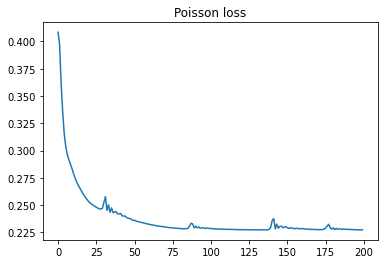

In [6]:
# train the rnn!
nepoch=200
lr=.05 # learning rate
losst, prd, latv = rnn0.train(net,x0,x0,nepoch,lr,device)    # Note here input=output=x0!; could also try to change the output to x1
plt.plot(losst.detach().cpu().numpy())
plt.title('Poisson loss')

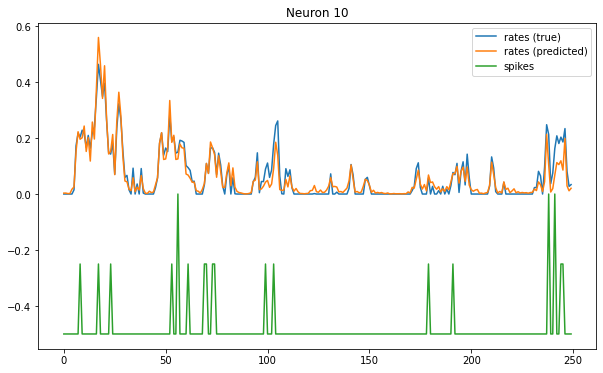

In [7]:
# visualize the performance of the rnn model
rpred = prd.detach().cpu().numpy()
nn = 10   # the number of the single neuron to be visualized
plt.figure(figsize=(10, 6))

plt.plot(fake_spk_rates[:,nn, 0])
plt.plot(rpred[:,nn, 0])
plt.plot(-.5 + fake_spk[:, nn, 0]/4)

plt.legend(['rates (true)', 'rates (predicted)', 'spikes'])
plt.title(f'Neuron {nn}')
plt.show()

In [8]:
## next: try the model with the real data